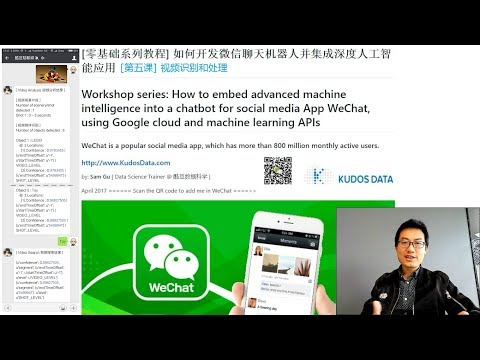

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('leVZjVahdKs')

# 如何使用和开发微信聊天机器人的系列教程
# A workshop to develop & use an intelligent and interactive chat-bot in WeChat

### WeChat is a popular social media app, which has more than 800 million monthly active users.

<img src='http://www.kudosdata.com/wp-content/uploads/2016/11/cropped-KudosLogo1.png' width=30% style="float: right;">
<img src='reference/WeChat_SamGu_QR.png' width=10% style="float: right;">

### http://www.KudosData.com

by: Sam.Gu@KudosData.com


May 2017 ========== Scan the QR code to become trainer's friend in WeChat ========>>

### 第五课：视频识别和处理
### Lesson 5: Video Recognition & Processing
* 识别视频的场景片段 (Detect shots change in video)
* 识别视频消息中的物体名字 (Recognize objects in video/shots)
* 直接搜索视频内容 (Search content in video)

### Using Google Cloud Platform's Machine Learning APIs

From the same API console, choose "Dashboard" on the left-hand menu and "Enable API".

Enable the following APIs for your project (search for them) if they are not already enabled:
<ol>
<li> Google Cloud Vision API </li>
<li> Google Cloud Speech API </li>
<li> Google Cloud Translate API </li>
<li> Google Cloud Natural Language API </li>
<li> Google Cloud Video API </li>
</ol>

Finally, because we are calling the APIs from Python (clients in many other languages are available), let's install the Python package (it's not installed by default on Datalab)

In [2]:
# Copyright 2016 Google Inc.
# Licensed under the Apache License, Version 2.0 (the "License"); 
# !pip install --upgrade google-api-python-client

### 导入需要用到的一些功能程序库：

In [3]:
import io, os, subprocess, sys, time, datetime, requests, itchat, json, numpy as np
from itchat.content import *
from googleapiclient.discovery import build
from IPython.display import HTML
# Python 2
if sys.version_info[0] < 3:
    import urllib2
# Python 3
else:
    import urllib.request

### Using Google Cloud Platform's Machine Learning APIs

First, visit <a href="http://console.cloud.google.com/apis">API console</a>, choose "Credentials" on the left-hand menu.  Choose "Create Credentials" and generate an API key for your application. You should probably restrict it by IP address to prevent abuse, but for now, just  leave that field blank and delete the API key after trying out this demo.

Copy-paste your API Key here:

In [4]:
# Here I read in my own API_KEY from a file, which is not shared in Github repository:
with io.open('../../API_KEY.txt') as fp: 
    for line in fp: APIKEY = line

# You need to un-comment below line and replace 'APIKEY' variable with your own GCP API key:
# APIKEY='AIzaSyCvxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [5]:
# Below is for GCP Video API
# video_service = build('videointelligence', 'v1', developerKey=APIKEY)
video_service = build('videointelligence', 'v1beta1', developerKey=APIKEY)
# check video processing progress
video_operation_service = build('videointelligence', 'v1', developerKey=APIKEY)

### 多媒体文件的二进制base64码转换 (Define media pre-processing functions)

In [6]:
# Import the base64 encoding library.
import base64
# Pass the media data to an encoding function.
def encode_media(media_file):
    with io.open(media_file, "rb") as media_file:
        media_content = media_file.read()
# Python 2
    if sys.version_info[0] < 3:
        return base64.b64encode(media_content).decode('ascii')
# Python 3
    else:
        return base64.b64encode(media_content).decode('utf-8')

### 机器智能API接口控制参数 (Define control parameters for API)

In [7]:
# API control parameter for 视频识别和处理 Video Recognition & Processing
parm_video_api_features = ['LABEL_DETECTION', 'SHOT_CHANGE_DETECTION']
# parm_video_api_features = ['LABEL_DETECTION']
# parm_video_api_features = ['SHOT_CHANGE_DETECTION']
parm_video_api_display_seconds = True # Ture: use seconds for display; False: use microseconds to display video shot duration
parm_video_response = {} # global variable

### 定义一个发起视频处理请求的小功能
Define utility function to call Video API:

In [8]:
# Invoke Video API

def KudosData_VIDEO_DETECTION(video_base64):
    print ('[INFOR] Start Video Analysis...')
##########################################################################################
# 1. Send request for video processing
##########################################################################################
    request1 = video_service.videos().annotate(body={
#               "inputUri": string,
              "inputContent": video_base64,
              "features": parm_video_api_features, # 'LABEL_DETECTION' & 'SHOT_CHANGE_DETECTION'
        })
    responses1 = request1.execute(num_retries=3)
    
    if 'name' in responses1: 
        print ('Internal video/operation name assinged : %s' % responses1['name'])
##########################################################################################
# 2. Check progress till completion (Video requires asynchronous long processing...)
##########################################################################################
        responses2 = KudosData_VIDEO_DETECTION_CHECK_PROCRESS(responses1['name'], APIKEY)
    else:
        print ('[ERROR] Calling Video API request failed. Please re-try.')
    
    return responses2

### 定义一个查询视频处理进展的小功能 Define utility function to check progress of Video API:

因为视频文件通常较大，处理费时。谷歌API接口采用了异步处理方式，所以会有此步骤。

In [9]:
# Keep checking progress of Video API processing, till full completion.

def KudosData_VIDEO_DETECTION_CHECK_PROCRESS(name, apikey):
    flag_completion = False
    operation_url = 'https://videointelligence.googleapis.com/v1/operations/' + name + '?key=' + apikey
#     print('operation_url : ', operation_url)
    while not flag_completion:
        # Python 2
        if sys.version_info[0] < 3:
            response_operation = json.loads(urllib2.urlopen(operation_url).read())
        # Python 3
        else:
#             response_operation = json.loads(urllib.request.urlopen(operation_url).read())
            response_operation = json.loads(urllib.request.urlopen(operation_url).read().decode('utf-8'))
        
        # define an array, containing 'progress %' of each Video API
        video_api_progress_pct = np.zeros(shape=(1, len(response_operation['metadata']['annotationProgress'])))
#         print('... length : %d' % len(response_operation['metadata']['annotationProgress']))
        for i in range(len(response_operation['metadata']['annotationProgress'])):
            if 'progressPercent' in response_operation['metadata']['annotationProgress'][i]:
                video_api_progress_pct[0][i] = response_operation['metadata']['annotationProgress'][i]['progressPercent']
#                 print ('>>> Video API {} Progress : {} %'.format(i+1, video_api_progress_pct[0][i]))
        print ('  overall progress : {} %'.format(np.mean(video_api_progress_pct[0])))
        if min(video_api_progress_pct[0]) == 100: 
            flag_completion = True
            print ('  Video API Completed !\n')

#         time.sleep(5)
        time.sleep(2)
#         print('... time.sleep')

    return response_operation

### 定义一个用关键词来搜索视频内容的小功能 Define utility function video search:

In [10]:
# return a list of shot locations, based on list of object name
def KudosData_search_location(list_object_name):   
#     print('Look for object : %s' % object_name)

    for i in range(len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'])):
        if parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['description'] == list_object_name[0]: 
#             print('Found  {} Locations   :'.format(
#                     len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])
#                 ))
            return parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations']

    return [] # If not found, return empty list []

### simple score integration: Certainty Factor
### CF = CF1 + CF2 * ( 1 - CF1 )
def KudosData_CF(cf1, cf2): return cf1 + cf2 * ( 1 - cf1)

# return a list of shot-locations, based on matched shot-loactions of two objects
def KudosData_match_location(list_location_1, list_location_2):   
    list_location_matched = []
    for i in range(len(list_location_1)):
        for j in range(len(list_location_2)):
            if list_location_1[i]['level'] == list_location_2[j]['level'] and \
               list_location_1[i]['segment'] == list_location_2[j]['segment']: 
#                 print('Shots matched: [i={}] [j={}]'.format(i, j))
                dict_location_matched = list_location_2[j].copy()
                dict_location_matched['confidence'] = KudosData_CF(list_location_1[i]['confidence'], 
                                                                   list_location_2[j]['confidence'])
                list_location_matched.append(dict_location_matched)
#     print(list_location_matched)
    return list_location_matched

def KudosData_search(list_object_name):
    if len(list_object_name) == 1:
        return KudosData_search_location([list_object_name[0]])    
    else:
        return KudosData_match_location(KudosData_search_location([list_object_name[0]]), 
                                        KudosData_search_location([list_object_name[1]]))
    

### 定义一个输出为视频分析结果的文本消息的小功能，用于微信回复 Define utility function for WeChat textual reply:

In [11]:
def KudosData_video_generate_reply(parm_video_response):
    video_reply = u'[ Video Analysis 视频分析结果 ]'
    
    # 1. 识别视频的场景片段 (Detect shots change in video)
    if parm_video_api_display_seconds: # our pre-defined control parm
        parm_denominator = 1000000 # dispay results in seconds
    else:
        parm_denominator = 1  # dispay results in microseconds

    video_reply += '\n' + (u'\n[ 视频场景片段 ]')
    video_reply += '\n' + (u'片段总数 No. scenery/shot : {}'
                           .format(len(parm_video_response['response']['annotationResults'][0]['shotAnnotations'])))
    for i in range(len(parm_video_response['response']['annotationResults'][0]['shotAnnotations'])):
    #     video_reply += (parm_video_response['response']['annotationResults'][0]['shotAnnotations'][i]) 
        if i == 0:
            video_reply += '\n' + (u'片段 Shot 1 : 0 ~ {} {}'
                .format(
                    int(parm_video_response['response']['annotationResults'][0]['shotAnnotations'][i]['endTimeOffset'])
                    /parm_denominator
                  , 'seconds' if parm_video_api_display_seconds else 'microseconds'
                ))
        else:
            video_reply += '\n' + (u'片段 Shot {} : {} ~ {} {}'
                .format(i+1
                  , int(parm_video_response['response']['annotationResults'][0]['shotAnnotations'][i]['startTimeOffset'])
                        /parm_denominator
                  , int(parm_video_response['response']['annotationResults'][0]['shotAnnotations'][i]['endTimeOffset'])
                        /parm_denominator
                  , 'seconds' if parm_video_api_display_seconds else 'microseconds'
                ))

    
    # 2. 识别视频消息中的物体名字 (Recognize objects in video/shots)
    
    video_reply += '\n' + (u'\n[ 视频物体识别 ]')
    video_reply += '\n' + (u'物体总数 No. objects : {}'
                    .format(len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'])))

    for i in range(len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'])):
        # video_reply +=  each object's name:
        video_reply += '\n'
        video_reply += '\n' + (u'物体 Obj {} : {}\n位于{}处片段 Locations: '.format(
                  i+1
                , parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['description']
                , len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])
            ))

            # video_reply +=  each object's location in video:
        for j in range(len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])):
    #         video_reply += (parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j])
            video_reply += '\n' + ('      [{}] Confidence : {} | {} | {} '.format(
                  j+1
                , parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['confidence']
                , parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['segment']
                , parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['level']
                  ))

    return video_reply

<font color='blue'>< Start of interactive demo ></font>

### 导入测试短片 Import video:

In [12]:
# video_file = 'reference/video.mp4'
# video_file = 'reference/SampleVideo_360x240_1mb.mp4'
video_file = 'reference/SampleVideo_360x240_2mb.mp4'

In [13]:
HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
         .format(encode_media(video_file)))

### 正式开始视频处理 Here we call Video API through our defined function:

In [14]:
# Send API request & Obtain results:
parm_video_response = KudosData_VIDEO_DETECTION(encode_media(video_file))

# Obtain results, without resending API request:
# parm_video_response = KudosData_VIDEO_DETECTION_CHECK_PROCRESS('asia-east1.11590064400054192243', APIKEY)

[INFOR] Start Video Analysis...
Internal video/operation name assinged : asia-east1.18222429504829065442
  overall progress : 0.0 %
  overall progress : 100.0 %
  Video API Completed !



### 查看原始格式的结果 View raw results:

In [15]:
parm_video_response

# metadata in response: Version of Video API used; Differenc Video APIs called, and start/end processing time.
# parm_video_response['metadata']

# actual video API detecion results in response:
# parm_video_response['response']['annotationResults'][0]

{u'done': True,
 u'metadata': {u'@type': u'type.googleapis.com/google.cloud.videointelligence.v1beta1.AnnotateVideoProgress',
  u'annotationProgress': [{u'progressPercent': 100,
    u'startTime': u'2017-06-11T03:24:30.389554Z',
    u'updateTime': u'2017-06-11T03:24:32.941077Z'},
   {u'progressPercent': 100,
    u'startTime': u'2017-06-11T03:24:30.389554Z',
    u'updateTime': u'2017-06-11T03:24:33.149530Z'}]},
 u'name': u'asia-east1.18222429504829065442',
 u'response': {u'@type': u'type.googleapis.com/google.cloud.videointelligence.v1beta1.AnnotateVideoResponse',
  u'annotationResults': [{u'labelAnnotations': [{u'description': u'Animal',
      u'languageCode': u'en-us',
      u'locations': [{u'confidence': 0.8764819,
        u'level': u'VIDEO_LEVEL',
        u'segment': {u'endTimeOffset': u'-1', u'startTimeOffset': u'-1'}},
       {u'confidence': 0.89243287,
        u'level': u'SHOT_LEVEL',
        u'segment': {u'endTimeOffset': u'8333309'}},
       {u'confidence': 0.4363374,
        u'

### * 识别视频的场景片段 (Detect shots change in video)

In [16]:
# parm_video_response['response']['annotationResults'][0]['shotAnnotations']

In [17]:
if parm_video_api_display_seconds: # our pre-defined control parm
    parm_denominator = 1000000 # dispay results in seconds
else:
    parm_denominator = 1  # dispay results in microseconds

print(u'[ 视频场景片段 ]')
print(u'片段总数 No. scenery/shots : {}'.format(len(parm_video_response['response']['annotationResults'][0]\
                                                         ['shotAnnotations'])))
for i in range(len(parm_video_response['response']['annotationResults'][0]['shotAnnotations'])):
#     print(parm_video_response['response']['annotationResults'][0]['shotAnnotations'][i]) 
    if i == 0:
        print(u'片段 Shot 1 : 0 ~ {} {}'
            .format(
                int(parm_video_response['response']['annotationResults'][0]['shotAnnotations'][i]\
                                        ['endTimeOffset'])/parm_denominator
              , 'seconds' if parm_video_api_display_seconds else 'microseconds'
            ))
    else:
        print(u'片段 Shot {} : {} ~ {} {}'
            .format(i+1
              , int(parm_video_response['response']['annotationResults'][0]['shotAnnotations'][i]\
                                        ['startTimeOffset'])/parm_denominator
              , int(parm_video_response['response']['annotationResults'][0]['shotAnnotations'][i]\
                                        ['endTimeOffset'])/parm_denominator
              , 'seconds' if parm_video_api_display_seconds else 'microseconds'
            ))

[ 视频场景片段 ]
片段总数 No. scenery/shots : 7
片段 Shot 1 : 0 ~ 8 seconds
片段 Shot 2 : 8 ~ 12 seconds
片段 Shot 3 : 13 ~ 15 seconds
片段 Shot 4 : 16 ~ 21 seconds
片段 Shot 5 : 21 ~ 23 seconds
片段 Shot 6 : 23 ~ 25 seconds
片段 Shot 7 : 25 ~ 26 seconds


### * 识别视频消息中的物体名字 (Recognize objects in video/shots)

In [18]:
# parm_video_response['response']['annotationResults'][0]['labelAnnotations']

In [19]:
print(u'[ 视频物体识别 ]')
print(u'物体总数 No. objects : {}'.format(len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'])))
print('')
for i in range(len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'])):
    # print each object's name:
    print(u'物体 Obj {} : {}'.format(
              i+1
            , parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['description']
        ))

[ 视频物体识别 ]
物体总数 No. objects : 23

物体 Obj 1 : Animal
物体 Obj 2 : Animation
物体 Obj 3 : Bud
物体 Obj 4 : Flora
物体 Obj 5 : Flower
物体 Obj 6 : Flowering plant
物体 Obj 7 : Giant panda
物体 Obj 8 : Grass
物体 Obj 9 : Grassland
物体 Obj 10 : Hare
物体 Obj 11 : Leaf
物体 Obj 12 : Meadow
物体 Obj 13 : Nature
物体 Obj 14 : Pasture
物体 Obj 15 : Petal
物体 Obj 16 : Plant
物体 Obj 17 : Plant stem
物体 Obj 18 : Rabbit
物体 Obj 19 : Rose
物体 Obj 20 : Sky
物体 Obj 21 : Sunlight
物体 Obj 22 : Tree
物体 Obj 23 : Wildlife


In [20]:
print(u'[ 视频物体识别 ]')
print(u'物体总数 No. objects : {}'.format(len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'])))

for i in range(len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'])):
    # print each object's name:
    print('')
    print(u'物体 Obj {} : {}\n位于{}处片段 Locations: '.format(
              i+1
            , parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['description']
            , len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])
        ))
    
        # print each object's related shot/location in video:
    for j in range(len(parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])):
#         print(parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j])
        print('   [{}] Confidence : {} | {} | {} '.format(
              j+1
            , parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['confidence']
            , parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['segment']
            , parm_video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['level']
              ))
  

[ 视频物体识别 ]
物体总数 No. objects : 23

物体 Obj 1 : Animal
位于6处片段 Locations: 
   [1] Confidence : 0.8764819 | {u'endTimeOffset': u'-1', u'startTimeOffset': u'-1'} | VIDEO_LEVEL 
   [2] Confidence : 0.89243287 | {u'endTimeOffset': u'8333309'} | SHOT_LEVEL 
   [3] Confidence : 0.4363374 | {u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'} | SHOT_LEVEL 
   [4] Confidence : 0.7916033 | {u'endTimeOffset': u'15999984', u'startTimeOffset': u'13000003'} | SHOT_LEVEL 
   [5] Confidence : 0.8764819 | {u'endTimeOffset': u'23533281', u'startTimeOffset': u'21733318'} | SHOT_LEVEL 
   [6] Confidence : 0.82209057 | {u'endTimeOffset': u'25666689', u'startTimeOffset': u'23599970'} | SHOT_LEVEL 

物体 Obj 2 : Animation
位于3处片段 Locations: 
   [1] Confidence : 0.60838264 | {u'endTimeOffset': u'-1', u'startTimeOffset': u'-1'} | VIDEO_LEVEL 
   [2] Confidence : 0.46997395 | {u'endTimeOffset': u'8333309'} | SHOT_LEVEL 
   [3] Confidence : 0.46998888 | {u'endTimeOffset': u'21666629', u'startTimeOffset': u'

### * 直接搜索视频内容 (Search content in video)
使用<font color='blue'>**文字**</font>关键词对视频<font color='blue'>**内容**</font>进行搜索

### 搜索示例 Demo:
单关键词

In [21]:
KudosData_search(['Animal'])

[{u'confidence': 0.8764819,
  u'level': u'VIDEO_LEVEL',
  u'segment': {u'endTimeOffset': u'-1', u'startTimeOffset': u'-1'}},
 {u'confidence': 0.89243287,
  u'level': u'SHOT_LEVEL',
  u'segment': {u'endTimeOffset': u'8333309'}},
 {u'confidence': 0.4363374,
  u'level': u'SHOT_LEVEL',
  u'segment': {u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'}},
 {u'confidence': 0.7916033,
  u'level': u'SHOT_LEVEL',
  u'segment': {u'endTimeOffset': u'15999984',
   u'startTimeOffset': u'13000003'}},
 {u'confidence': 0.8764819,
  u'level': u'SHOT_LEVEL',
  u'segment': {u'endTimeOffset': u'23533281',
   u'startTimeOffset': u'21733318'}},
 {u'confidence': 0.82209057,
  u'level': u'SHOT_LEVEL',
  u'segment': {u'endTimeOffset': u'25666689',
   u'startTimeOffset': u'23599970'}}]

In [22]:
KudosData_search(['Sky'])

[{u'confidence': 0.81967264,
  u'level': u'SHOT_LEVEL',
  u'segment': {u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'}},
 {u'confidence': 0.496,
  u'level': u'SHOT_LEVEL',
  u'segment': {u'endTimeOffset': u'23533281',
   u'startTimeOffset': u'21733318'}}]

In [23]:
KudosData_search(['Sam'])

[]

### 多关键词查找 Joint search by keywords: **'Animal' & 'Sky'**

[ 搜索视频内容 ] **'Animal'**
*   [2] Confidence : 0.89243287 | SHOT_LEVEL | {u'endTimeOffset': u'8333309'} 
*   [5] Confidence : **0.8764819** | SHOT_LEVEL | <font color='blue'>{u'endTimeOffset': u'23533281', u'startTimeOffset': u'21733318'}</font>
*   [1] Confidence : 0.8764819 | VIDEO_LEVEL | {u'endTimeOffset': u'-1', u'startTimeOffset': u'-1'}
*   [6] Confidence : 0.82209057 | SHOT_LEVEL | {u'endTimeOffset': u'25666689', u'startTimeOffset': u'23599970'} 
*   [4] Confidence : 0.7916033 | SHOT_LEVEL | {u'endTimeOffset': u'15999984', u'startTimeOffset': u'13000003'} 
*   [3] Confidence : **0.4363379** | SHOT_LEVEL | <font color='blue'>{u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'}</font>

[ 搜索视频内容 ] **'Sky'**
*   [1] Confidence : **0.81967264** | SHOT_LEVEL | <font color='blue'>{u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'}</font>
*   [2] Confidence : **0.496** | SHOT_LEVEL | <font color='blue'>{u'endTimeOffset': u'23533281', u'startTimeOffset': u'21733318'}</font>


### 对于多关键词，怎样找出最相关的视频片段？ How to rank the video shot relevance for a combination of keywords?
A simpel method is to combine confidence pair by 'Certainty Factor': CF = Confidence1 + Confidence2 * ( 1 - Confidence1 )


In [24]:
# CF = 0.81967264 + 0.4363379 * ( 1 - 0.81967264 ) = ?
print('CF (combined confidence score) = {}'.format(0.81967264 + 0.4363379 * ( 1 - 0.81967264 )))

CF (combined confidence score) = 0.898356301575


In [25]:
# * CF = 0.496 + 0.8764819 * ( 1 - 0.496 ) = ?
print('CF (combined confidence score) = {}'.format(0.496 + 0.8764819 * ( 1 - 0.496 )))

CF (combined confidence score) = 0.9377468776


### 搜索示例 Demo:
多关键词

In [26]:
KudosData_search(['Animal', 'Sky'])

[{u'confidence': 0.898356211411264,
  u'level': u'SHOT_LEVEL',
  u'segment': {u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'}},
 {u'confidence': 0.9377468776,
  u'level': u'SHOT_LEVEL',
  u'segment': {u'endTimeOffset': u'23533281',
   u'startTimeOffset': u'21733318'}}]

In [27]:
KudosData_search(['Animal', 'Grassland'])

[{u'confidence': 0.968358931565536,
  u'level': u'SHOT_LEVEL',
  u'segment': {u'endTimeOffset': u'23533281',
   u'startTimeOffset': u'21733318'}}]

<font color='blue'>
[提问] 如果是三个或更多关键词呢，怎么处理？ 
[Question] Which video shot is most relvant for: Animal, Sky, and Grassland? And why?
</font>

In [28]:
HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
     .format(encode_media(video_file)))

In [29]:
KudosData_search(['Animal', 'SamGu'])

[]

<font color='blue'>< End of interactive demo ></font>

In [30]:
print(KudosData_video_generate_reply(parm_video_response))

[ Video Analysis 视频分析结果 ]

[ 视频场景片段 ]
片段总数 No. scenery/shot : 7
片段 Shot 1 : 0 ~ 8 seconds
片段 Shot 2 : 8 ~ 12 seconds
片段 Shot 3 : 13 ~ 15 seconds
片段 Shot 4 : 16 ~ 21 seconds
片段 Shot 5 : 21 ~ 23 seconds
片段 Shot 6 : 23 ~ 25 seconds
片段 Shot 7 : 25 ~ 26 seconds

[ 视频物体识别 ]
物体总数 No. objects : 23

物体 Obj 1 : Animal
位于6处片段 Locations: 
      [1] Confidence : 0.8764819 | {u'endTimeOffset': u'-1', u'startTimeOffset': u'-1'} | VIDEO_LEVEL 
      [2] Confidence : 0.89243287 | {u'endTimeOffset': u'8333309'} | SHOT_LEVEL 
      [3] Confidence : 0.4363374 | {u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'} | SHOT_LEVEL 
      [4] Confidence : 0.7916033 | {u'endTimeOffset': u'15999984', u'startTimeOffset': u'13000003'} | SHOT_LEVEL 
      [5] Confidence : 0.8764819 | {u'endTimeOffset': u'23533281', u'startTimeOffset': u'21733318'} | SHOT_LEVEL 
      [6] Confidence : 0.82209057 | {u'endTimeOffset': u'25666689', u'startTimeOffset': u'23599970'} | SHOT_LEVEL 

物体 Obj 2 : Animation
位于3处片段 Lo

### 用微信App扫QR码图片来自动登录

In [ ]:
itchat.auto_login(hotReload=True) # hotReload=True: 退出程序后暂存登陆状态。即使程序关闭，一定时间内重新开启也可以不用重新扫码。
# itchat.auto_login(enableCmdQR=-2) # enableCmdQR=-2: 命令行显示QR图片

In [ ]:
# @itchat.msg_register([VIDEO], isGroupChat=True)
@itchat.msg_register([VIDEO])
def download_files(msg):
    msg.download(msg.fileName)
    print('\nDownloaded video file name is: %s' % msg['FileName'])
    ##############################################################################################################
    #                                          call video analysis APIs                                          #
    ##############################################################################################################
    global parm_video_response # save into global variable, which can be accessed by next WeChat keyword search
    parm_video_response = KudosData_VIDEO_DETECTION(encode_media(msg['FileName']))
    ##############################################################################################################
    #                                          format video API results                                          #
    ##############################################################################################################
    video_analysis_reply = KudosData_video_generate_reply(parm_video_response)
    print ('')
    print(video_analysis_reply)
    return video_analysis_reply

In [ ]:
# 单聊模式，基于关键词进行视频搜索：
@itchat.msg_register([TEXT])
def text_reply(msg):
#     if msg['isAt']:
        list_keywords = [x.strip() for x in msg['Text'].split(',')]
        # call video search function:
        search_responses = KudosData_search(list_keywords) # return is a list
        # Format search results:
        search_reply = u'[ Video Search 视频搜索结果 ]' + '\n'
        if len(search_responses) == 0:
            search_reply += u'[ Nill 无结果 ]'
        else:
            for i in range(len(search_responses)): search_reply += '\n' + str(search_responses[i])
        print ('')
        print (search_reply)
        return search_reply

In [ ]:
# 群聊模式，基于关键词进行视频搜索：
@itchat.msg_register([TEXT], isGroupChat=True)
def text_reply(msg):
    if msg['isAt']:
        list_keywords = [x.strip() for x in msg['Text'].split(',')]
        # call video search function:
        search_responses = KudosData_search(list_keywords) # return is a list
        # Format search results:
        search_reply = u'[ Video Search 视频搜索结果 ]' + '\n'
        if len(search_responses) == 0:
            search_reply += u'[ Nill 无结果 ]'
        else:
            for i in range(len(search_responses)): search_reply += '\n' + str(search_responses[i])
        print ('')
        print (search_reply)
        return search_reply

In [ ]:
itchat.run()

<font color='blue'>
<font color='blue'>
[提问] 是不是可以用图片来搜索视频内容？需要怎么处理？ 
[Question] Can we use image as input to search video content? How?
</font>


In [ ]:
# interupt kernel, then logout
itchat.logout() # 安全退出

### 恭喜您！已经完成了：
### 第五课：视频识别和处理
### Lesson 5: Video Recognition & Processing
* 识别视频的场景片段 (Detect shots change in video)
* 识别视频消息中的物体名字 (Recognize objects in video/shots)
* 直接搜索视频内容 (Search content in video)

### 下一课是:
### 第六课：互动智能机器人应用
### Lesson 6: Intelligent & Interactive Chat-bot Applications
* 多语言翻译器 (Language translator)
* 图文多媒体的订阅和点播 (Multi-media broadcast & on-demand subscription)
* 文章的概括和缩写 (Automatic article summary)
* 不良图片的识别；不良视频片段的自动识别和定位 (Explicit content detector: i.e. adult content or violent content)
* 基于商品图片的搜索和商家价格比较 (Best retail price finder using an image of goods)

<img src='http://www.kudosdata.com/wp-content/uploads/2016/11/cropped-KudosLogo1.png' width=30% style="float: right;">
<img src='reference/WeChat_SamGu_QR.png' width=10% style="float: left;">

